In [2]:
import netket as nk
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import jax.numpy as jnp

sys.path.append(os.path.abspath(".."))
from hamiltonian import cTFIM
from Custom_nk.nh_variance_opt import NHDriver, NHDriverSymm
from Custom_nk.nh_mcstate import NHMCState

In this tutorial, we demonstrate how to use the non-Hermitian (NH) driver to perform variance minimization. The driver is built on top of NetKet and can be employed in much the same way as the standard NetKet drivers.

As an example, we will apply it to the non-Hermitian Transverse-Field Ising Model (NH-TFIM), using the fixed-start method to approximate its ground state. We begin by specifying the parameters of both the Hamiltonian and the Monte Carlo (MC) simulation.

In [15]:
n_dim = 1
L = 10
lam = 0.5
h = 2.5
k = 0.5

n_steps = 500
n_samples = 2**12
n_chains = 128
chunk_size = None

fixed_steps_ratio = 0.05
transition_steps_ratio = 0.2

hi = nk.hilbert.Spin(s=1/2, N=L**n_dim)
g = nk.graph.Hypercube(length=L, n_dim=n_dim, pbc=True)

sampler = nk.sampler.MetropolisLocal(hi, n_chains=n_chains) 
optimizer = nk.optimizer.Sgd(learning_rate=1e-3)
preconditioner = nk.optimizer.SR(diag_shift=1e-3, holomorphic=True)

Next, we introduce the Hamiltonian:
\begin{equation}
    H = -\lambda\sum_{\langle i,j\rangle}\sigma_i^z\sigma_j^z-h\sum_i\sigma_i^x-ik\sum_i\sigma_i^z.
\end{equation}

We implement this in the cTFIM class, which provides convenient access to the Hamiltonian $H$, its adjoint $H^\dagger$, and a lower bound on the spectrum. The latter will serve as an initial estimate for the ground-state energy.

In [16]:
Hamiltonian = cTFIM(hi, g, lam, h, k)
H = Hamiltonian.operator
H_adj = Hamiltonian.adjoint_operator
eps_init = Hamiltonian.lower_bound

We now turn to the definition of our wavefunctions. In the general approach, we optimize two states simultaneously: the trial wavefunction $\ket{\psi}$and its biorthogonal partner $\ket{\tilde\psi}$. 

To implement this, we construct two independent Neural Quantum States (NQSs), each based on a Restricted Boltzmann Machine (RBM) with complex-valued parameters. These are implemented with a custom variational state, NHMCState, which allows us to evaluate biorthogonal expectation values of observables via the .nh_expect method.

When creating an NHMCState, one must also specify whether the variational state is to be optimized as a right or a left eigenstate. This choice is controlled by the bstate property.

In [17]:
model_l = nk.models.RBM(param_dtype=jnp.complex128)
model_r = nk.models.RBM(param_dtype=jnp.complex128)
vs_tilde = NHMCState(bstate="left", sampler=sampler, model=model_l, n_samples=n_samples, chunk_size=chunk_size)
vs = NHMCState(bstate="right", sampler=sampler, model=model_r, n_samples=n_samples, chunk_size=chunk_size)

As an example, let us compute the biorthogonal expectation value of the Hamiltonian, defined as
\begin{equation}
    \langle H\rangle_{LR} = \frac{\bra{\tilde\psi}H\ket{\psi}}{\bra{\tilde\psi}\psi\rangle}.
\end{equation}

This quantity can be evaluated within the NHMCState using the .nh_expect method. Two different Monte Carlo estimators are available, depending on whether the sampling is performed with $|\psi|^2$ or with $|\tilde\psi|^2$. The choice of estimator is controlled by the PDF argument passed to .nh_expect.

In [6]:
E_r = vs.nh_expect(O=H, vs_tilde=vs_tilde, PDF="right")
E_l = vs.nh_expect(O=H, vs_tilde=vs_tilde, PDF="left")

print("Expectation value with psi as PDF: ", E_r)
print("Expectation value with psi tilde as PDF: ", E_l)

Expectation value with psi as PDF:  -24.959-0.017j ± 0.041 [σ²=6.903]
Expectation value with psi tilde as PDF:  -25.016-0.013j ± 0.041 [σ²=6.998]


As expected, the two estimators yield compatible results. However, it is important to note that these values do not yet represent the true biorthogonal expectation value, since the two wavefunctions are not currently dual to one another. Only after the optimization has converged will the correct biorthogonal expectation values of operators be obtained.

We are now ready to define the non-Hermitian driver and begin the optimization of the two wavefunctions.

In [18]:
gs = NHDriver(
    variational_state=vs,
    variational_state_tilde=vs_tilde,
    hamiltonian=H,
    hamiltonian_adj=H_adj,
    optimizer=optimizer,
    preconditioner=preconditioner
)

log = nk.logging.RuntimeLog()

gs.run(
    n_iter=n_steps, 
    fixed_steps_ratio=fixed_steps_ratio, 
    transition_steps_ratio=transition_steps_ratio,
    eps_init=eps_init,
    out=log
    )

  0%|          | 0/500 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Variance Left', 'Variance Right', 'Eps'],)

In [8]:
# We compute the energy with ED to compare our result
from scipy.sparse.linalg import eigs

E_gs_ED = eigs(H.to_sparse(), return_eigenvectors=False, k=3, which = "SR")[-1]

Final relative error: 9.52823252953604e-06


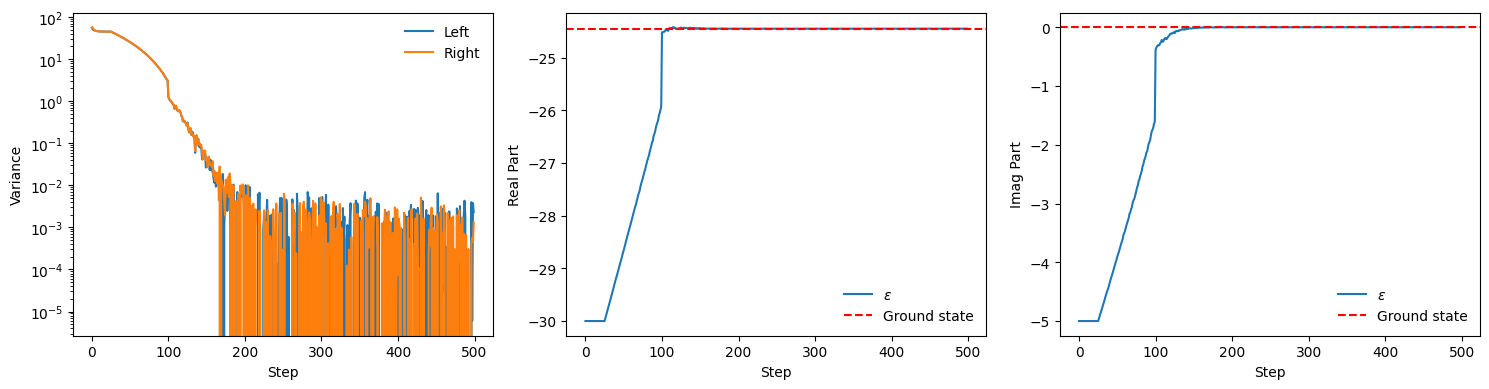

In [20]:
plt.figure(figsize=(15, 4))

iters = log["Variance Left"]["iters"]

plt.subplot(1, 3, 1)
plt.plot(iters, np.real(log["Variance Left"]["Mean"]), label="Left")
plt.plot(iters, np.real(log["Variance Right"]["Mean"]), label="Right")
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Variance")
plt.legend(frameon=False)

plt.subplot(1, 3, 2)
plt.plot(iters, np.real(log["Eps"]["value"]), label=r"$\varepsilon$")
plt.axhline(np.real(E_gs_ED), color="red", ls="--", label="Ground state")
plt.xlabel("Step")
plt.ylabel("Real Part")
plt.legend(frameon=False)

plt.subplot(1, 3, 3)
plt.plot(iters, np.imag(log["Eps"]["value"]), label=r"$\varepsilon$")
plt.axhline(np.imag(E_gs_ED), color="red", ls="--", label="Ground state")
plt.xlabel("Step")
plt.ylabel("Imag Part")
plt.legend(frameon=False)

plt.tight_layout()
print("Final relative error:", np.abs(E_gs_ED - log["Eps"]["value"][-1]) / np.abs(E_gs_ED))

We obtain a nice final error with respect to ED. However, we can nearly halve the computational cost of our method by exploiting the system’s symmetry. The NH-TFIM is pseudo-Hermitian, meaning there exists an operator $\eta$ such that $H^\dagger=\eta^\dagger H\eta$, and $\ket{\tilde\psi}=\eta\ket\psi$, so that we only need to optimize a single NQS, obtaining the other via $\eta$.

In this case, $\eta$ corresponds to the complex conjugation operator, and we have implemented a driver that takes advantage of this symmetry. Furthermore, by specifying the system symmetry in the variational state, we can now compute biorthogonal expectation values using the .nh_expect_symm method.

In [10]:
vs = NHMCState(bstate="right", sampler=sampler, model=model_r, n_samples=n_samples, chunk_size=chunk_size, symmetry="cc")

print("Biorthogonal expectation value using the symmetric estimator: ", vs.nh_expect_symm(H))

Biorthogonal expectation value using the symmetric estimator:  -25.010-0.018j ± 0.041 [σ²=7.017]


In [11]:
gs = NHDriverSymm(
    hamiltonian=H, 
    hamiltonian_adj=H_adj, 
    variational_state=vs, 
    optimizer=optimizer, 
    preconditioner=preconditioner
    )

log = nk.logging.RuntimeLog()

gs.run(
    n_iter=n_steps, 
    fixed_steps_ratio=fixed_steps_ratio, 
    transition_steps_ratio=transition_steps_ratio,
    eps_init=eps_init,
    out=log
    )

  0%|          | 0/500 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Variance', 'Eps'],)

Final relative error: 1.134331140784541e-05


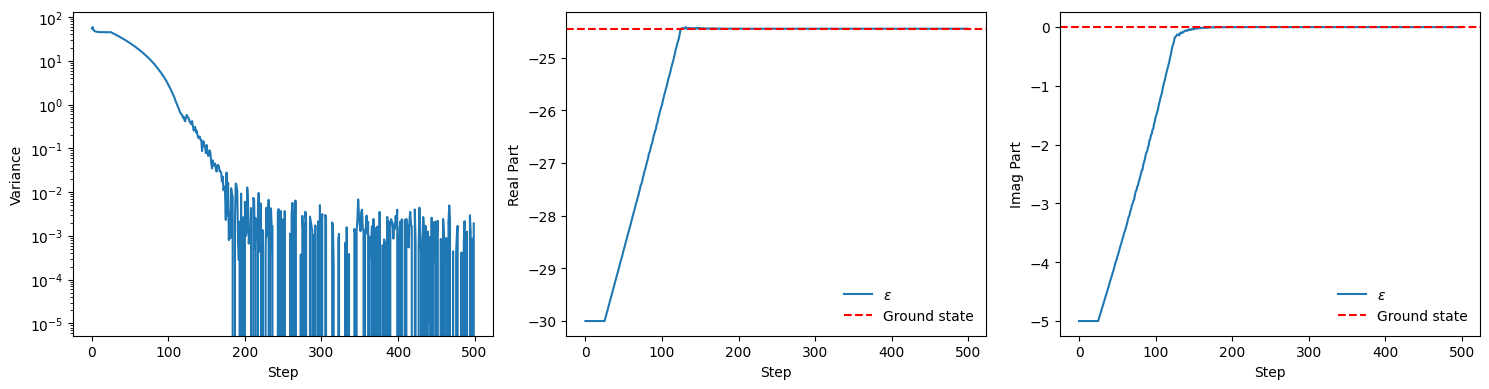

In [14]:
plt.figure(figsize=(15, 4))

iters = log["Variance"]["iters"]

plt.subplot(1, 3, 1)
plt.plot(iters, np.real(log["Variance"]["Mean"]))
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Variance")

plt.subplot(1, 3, 2)
plt.plot(iters, np.real(log["Eps"]["value"]), label=r"$\varepsilon$")
plt.axhline(np.real(E_gs_ED), color="red", ls="--", label="Ground state")
plt.xlabel("Step")
plt.ylabel("Real Part")
plt.legend(frameon=False)

plt.subplot(1, 3, 3)
plt.plot(iters, np.imag(log["Eps"]["value"]), label=r"$\varepsilon$")
plt.axhline(np.imag(E_gs_ED), color="red", ls="--", label="Ground state")
plt.xlabel("Step")
plt.ylabel("Imag Part")
plt.legend(frameon=False)

plt.tight_layout()
print("Final relative error:", np.abs(E_gs_ED - log["Eps"]["value"][-1]) / np.abs(E_gs_ED))